In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import re
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

## Enron Email Dataset
https://www.kaggle.com/wcukierski/enron-email-dataset

In [3]:
def search_emails(df, query, by_name=True, by_org=False, by_text=False):
    results = pd.DataFrame()
    
    if by_name:
        results = pd.concat([
            results,
            df[df.sender.apply(lambda x: x.split('@')[0]).str.contains(query)]
        ])

    if by_org:
        results = pd.concat([
            results,
            df[df.sender.apply(lambda x: x.split('@')[-1]).str.contains(query)]
        ])

    if by_text:
        results = pd.concat([
            results,
            df[df.text.str.contains(query)]
        ])
    return results.sort_values(by='date').drop_duplicates()

In [4]:
from collections import Counter

class PGraph:
    def __init__(self, nodes, edges):
        self.nodes = nodes
        self.edges = edges
        
    def node_values(self, idxs, cols=None):
        idxs = list(idxs)
        if cols is None:
            cols = self.nodes.columns.tolist()
            
        return [x for x in self.nodes.loc[idxs][cols].values.reshape(-1) if x!='']
    
    def edge_values(self, idxs, cols=None):
        idxs = list(idxs)
        if cols is None:
            cols = self.nodes.columns.tolist()
            
        if 'sender' in cols:
            return [int(x) for x in self.edges.loc[idxs][cols].values.reshape(-1) if x!='']
        else:
            return [x for x in self.edges.loc[idxs][cols].values.reshape(-1) if x!='']
        
    def uniq_node_values(self, idxs, cols):
        return list(sorted(set(self.node_values(idxs, cols))))
    
    def uniq_edge_values(self, idxs, cols):
        return list(sorted(set(self.edge_values(idxs, cols))))
    
    def node_counts(self, idxs, cols):
        return Counter(self.node_values(idxs, cols))
    
    def edge_counts(self, idxs, cols):
        return Counter(self.edge_values(idxs, cols))

In [5]:
from datetime import datetime
from src.spellcheck import find_close


def filterby_date(df, start_date=datetime(1979, 1, 1), end_date=datetime(2005, 1, 1)):
    return df[(df.datetime>=start_date)&(df.datetime<=end_date)]

node_attrs = ['name1', 'name2', 'email1', 'email2', 'org1', 'org2']
edge_bounds = ['sender', 'receiver1', 'receiver2', 'receiver3']

def infer_name(row):
    name = row['email1'].split('@')[0]
    pieces = [x for x in re.split(r'[\.\-\_]', name) if len(x)>0]
    if len(pieces)>=2 and len(pieces[0])>=2:
        return ' '.join(pieces)
    else:
        return ''
    
def infer_org(row):
    suffix = row['email1'].split('@')[-1]
    pieces = [x for x in re.split(r'\.', suffix) if len(x)>0]
    if len(pieces)==2 and pieces[0] not in ['aol', 'earthlink']:
        return pieces[0]
    elif len(pieces)>2 and pieces[-1]=='edu':
        return pieces[-2]
    else:
        return ''
    
def emails2nodes(df):
    emails = np.concatenate([df[x].unique() for x in ['sender', 'recipient1', 'recipient2', 'recipient3']])
    emails = [x for x in np.sort(np.unique(emails)) if len(x)>0]
    
    nodes = pd.DataFrame({k:['']*len(emails) if k!='email1' else emails for k in node_attrs})
    nodes['name1'] = nodes.apply(infer_name, axis=1)
    nodes['org1'] = nodes.apply(infer_org, axis=1)
    nodes = nodes.sort_values(by='org1').reset_index(drop=True)
    return nodes

def emails2edges(df, nodes):
    emails2idx = {v:k for k,v in nodes.to_dict()['email1'].items()}
    
    edges = pd.DataFrame({
        'sender':list(map(emails2idx.get, df['sender'])),
        'receiver1':list(map(emails2idx.get, df['recipient1'])),
        'receiver2':list(map(emails2idx.get, df['recipient2'])),
        'receiver3':list(map(emails2idx.get, df['recipient3'])),
        'type':['email']*len(df),
        'datetime':df['date'].tolist(),
        'desc':df['subject'].tolist(),
        'data':df['text'].tolist()
    }).fillna('')
    
    return edges

def invoices2nodes(df):
    nodes_dict = {k:[] for k in ['name1', 'name2', 'email1', 'email2', 'org1', 'org2']}
    
    for i,row in df.iterrows():
        sender = row['recipient'].lower()
        recipient = row['vendor_name']
        datetime = row['date']
        desc = row['description']
        data = row['amount']

        nodes_dict['name1'].append(sender)
        nodes_dict['name2'].append('')
        nodes_dict['email1'].append('')
        nodes_dict['email2'].append('')
        nodes_dict['org1'].append('enron')
        nodes_dict['org2'].append('')
        
        nodes_dict['name1'].append('')
        nodes_dict['name2'].append(recipient)
        nodes_dict['email1'].append('')
        nodes_dict['email2'].append('')
        nodes_dict['org1'].append(recipient)
        nodes_dict['org2'].append('')
        
    return pd.DataFrame(nodes_dict).drop_duplicates().reset_index(drop=True)

def invoices2edges(df, nodes):
    receiver2idx = {v:k for k,v in nodes.to_dict()['org1'].items() if v!=''}
    sender2idx = {v:k for k,v in nodes.to_dict()['name1'].items() if v!=''}
    
    df = df[df['recipient']!='']
    
    edges = pd.DataFrame({
        'sender':list(map(sender2idx.get, df['recipient'])),
        'receiver1':list(map(receiver2idx.get, df['vendor_name'])),
        'receiver2':['']*len(df),
        'receiver3':['']*len(df),
        'type':['invoice']*len(df),
        'datetime':df['date'].tolist(),
        'desc':df['description'].tolist(),
        'data':df['amount'].tolist()
    }).fillna('')
    
    return edges


class ForensicGraph(PGraph):
    @classmethod
    def from_emails(cls, emails_path):
        emails = pd.read_csv(emails_path).fillna('')
        emails['date'] = pd.to_datetime(emails['date'])
        nodes = emails2nodes(emails)
        edges = emails2edges(emails, nodes)
        return cls(nodes=nodes, edges=edges)
    
    def __init__(self, nodes, edges):
        super().__init__(nodes, edges)
        self.add_invoices()
        
    def add_invoices(self, inv_path='data/invoices/invoices_clean.csv'):
        nodes_start, edges_start = self.nodes.index[-1]+1, self.edges.index[-1]+1
        
        invoices = pd.read_csv(inv_path).fillna('')
        invoices.date = pd.to_datetime(invoices.date)
        
        nodes = invoices2nodes(invoices)
        edges = invoices2edges(invoices, nodes)

        nodes.index+=nodes_start
        edges.index+=edges_start
        
        edges['sender']+=nodes_start
        edges['receiver1']+=nodes_start
        
        self.nodes = pd.concat([self.nodes, nodes])
        self.edges = pd.concat([self.edges, edges])
        
    def make_subgraph(self, f1, f2=None, start_date=datetime(2001, 1, 1), end_date=datetime(2002, 1, 1)):
        edges = filterby_date(self.edges, start_date=start_date, end_date=end_date)
        edges = self.edges_from_nodes(*f1, edges=edges)
        
        if f2 is not None:
            edges = self.edges_from_nodes(*f2, edges=edges)
            
        nodes = self.nodes_from_edges(*edges.index)
        return PGraph(nodes=nodes, edges=edges)
        
    def edges_from_nodes(self, *nodes, edges=None):
        if edges is None:
            return self.edges[self.edges[edge_bounds].isin(nodes).any(axis=1)]
        else:
            return edges[edges[edge_bounds].isin(nodes).any(axis=1)]
    
    def nodes_from_edges(self, *edges, nodes=None):
        if nodes is None:
            return self.nodes[self.nodes.index.isin(self.uniq_edge_values(edges, edge_bounds))]
        else:
            return nodes[nodes.index.isin(self.uniq_edge_values(edges, edge_bounds))]
    
    def _merged_row(self, *idxs):
        idxs = list(idxs)
        def pair(values):
            return values+['']*(2-len(values)) if len(values)<2 else values[:2]
            
        row = {}
        row['name1'], row['name2'] = pair(self.uniq_node_values(idxs, ['name1', 'name2']))
        row['email1'], row['email2'] = pair(self.uniq_node_values(idxs, ['email1', 'email2']))
        row['org1'], row['org2'] = pair(self.uniq_node_values(idxs, ['org1', 'org2']))
        return pd.Series(row)

    def merge(self, *idxs):
        if len(idxs)>1:
            idxs = list(sorted(idxs))
            prime, aliases = idxs[0], idxs[1:]
            merged_row = self._merged_row(*idxs)
            self.nodes.loc[prime].update(self._merged_row(*idxs))
            self.nodes = self.nodes.drop(index=aliases)

            edge_repl = dict(zip(aliases, [prime]*len(aliases))) 
            self.edges = self.edges.replace({k:edge_repl for k in edge_bounds})
            
    def search_name(self, name):
        idxs = set()
        idxs.update(find_close(name, self.nodes))
        
        pieces = [x.strip() for x in name.split() if len(x.strip())>0]
        if len(pieces)>=2:
            alt_1 = '.'.join([pieces[0][0], pieces[-1]])
            idxs.update(find_close(alt_1, self.nodes))
            
            if len(pieces)==2:
                alt_2 = '  '.join([pieces[0], pieces[1]])
                idxs.update(find_close(alt_2, self.nodes))
        return list(sorted(idxs))
    
    def search_names(self, names):
        names = [x.strip() for x in names.split(',')]
        return [self.search_name(x) for x in names]
    
def node_summaries(idxs, nodes):
    def summarize(row):
        name=row['name1']
        tag=row['email1'].split('@')[0]
        return name, row['org1'], tag
    return {idx:summarize(nodes.loc[idx]) for idx in idxs}
    
def edge_summaries(idxs, nodes, edges):
    def summarize(row):
        sender_row = nodes.loc[int(row['sender'])]
        receiver_row = nodes.loc[int(row['receiver1'])]
        sender = sender_row['name1'] if sender_row['name1'] is not '' else sender_row['email1'].split('@')[0]
        receiver = receiver_row['name1'] if receiver_row['name1'] is not '' else receiver_row['email1'].split('@')[0]
        return sender, receiver, row['datetime'].date(), row['desc'][:10]
    return {idx:summarize(edges.loc[idx]) for idx in idxs}

def get_orgs(idxs, nodes):
    return [x[0] for x in Counter(nodes.loc[idxs]['org1']).most_common() if len(x[0])>0]

def filter_nodes_by_org(idxs, nodes, org):
    filtered_nodes = nodes.loc[idxs]
    return filtered_nodes[filtered_nodes['org1'].isin(org)].index

def filter_nodes_by_date(idxs, edges, start_date, end_date):
    edges = filterby_date(edges, start_date=start_date, end_date=end_date)
    all_nodes = [int(x) for x in edges[edge_bounds].values.reshape(-1) if x!='']
    return [x for x in idxs if x in all_nodes]

In [6]:
graph = ForensicGraph.from_emails('data/enron/emails_filtered.csv')

In [7]:
graph.edges[graph.edges.type=='email'].head()
graph.edges[graph.edges.type=='invoice'].head()

,sender,receiver1,receiver2,receiver3,type,datetime,desc,data
0,6779,1393,,,email,1979-12-31 16:00:00,Re: Update from cousins in Missouri,Letter dictated by Ken Lay Hello Janice: I enj...
1,4953,2794,,,email,1979-12-31 16:00:00,Re: Energy TF Final Report,Mr. Sikes - Kenneth L. Lay is the Chairman of ...
2,4380,9285,,,email,1979-12-31 16:00:00,"Re: BlueDog Change Order #2, Rev 4","Hi Brian, Here are my observations/questions: ..."
3,5816,4015,,,email,1979-12-31 16:00:00,Re: ERMS traders in EnPower,Enron Capital & Trade Resources Corp.
4,6439,9521,,,email,1979-12-31 16:00:00,,"George, In response to your ideas Time and cos..."


,sender,receiver1,receiver2,receiver3,type,datetime,desc,data
62566,14779,14780,,,invoice,1998-02-16,Workforce Now\nADP Flexible Spending\nAccounts...,563.63
62567,14779,14780,,,invoice,1998-03-23,ADP Workforce Now\nADP Flexible Spending\nAcco...,555.3
62568,14782,14783,,,invoice,1998-05-21,Review materials from client re alleged fraud ...,3420
62569,14784,14785,,,invoice,1998-10-19,,116.69
62570,14786,14787,,,invoice,1999-03-21,,1160.89


In [8]:
finder = graph.search_names('kenneth lay, jeff skilling')
graph.nodes.loc[finder[0]]
graph.nodes.loc[finder[1]]

,name1,name2,email1,email2,org1,org2
4136,,,klay@enron.com,,enron,
4240,,,k_lay@enron.com,,enron,
4490,kenneth lay,,kenneth_lay@enron.com,,enron,
4498,kenneth lay,,kenneth.lay@enron.com,,enron,
14779,kenneth s lay,,,,enron,
14792,kenneth lay,,,,enron,


,name1,name2,email1,email2,org1,org2
3576,,,kskilling@ehshouston.org,,ehshouston,
5539,,,skilling@enron.com,,enron,
8635,jeff skilling,,jeff_skilling@enron.com,,enron,
8702,jeff skilling,,jeff.skilling@enron.com,,enron,
13812,,,tskilling@tribune.com,,tribune,
14782,jeff skilling,,,,enron,
14786,jeff t skilling,,,,enron,


In [9]:
graph.merge(*finder[0])
graph.merge(8635, 8702)

finder = graph.search_names('kenneth lay, jeff skilling')
graph.nodes.loc[finder[0]]
graph.nodes.loc[finder[1]]

,name1,name2,email1,email2,org1,org2
4136,kenneth lay,kenneth s lay,k_lay@enron.com,kenneth.lay@enron.com,enron,


,name1,name2,email1,email2,org1,org2
3576,,,kskilling@ehshouston.org,,ehshouston,
5539,,,skilling@enron.com,,enron,
8635,jeff skilling,,jeff.skilling@enron.com,jeff_skilling@enron.com,enron,
13812,,,tskilling@tribune.com,,tribune,
14782,jeff skilling,,,,enron,
14786,jeff t skilling,,,,enron,


In [10]:
poi = [4136]
assoc = graph.nodes_from_edges(*graph.edges_from_nodes(*poi).index).drop(index=poi).index.tolist()
orgs = [x[0] for x in Counter(graph.nodes.loc[assoc].org1).most_common()]

In [11]:
len(poi)
len(assoc)
len(orgs)

1

1286

505

In [13]:
toporgs = [
    x[0] 
    for x in Counter(graph.nodes.loc[assoc].org1).most_common() 
    if x[0] not in ['', 'enron', 'attbi', 'excite', 'home', 'att', 'pacbell', 'yahoo', 'msn', 'hotmail', 'juno', 'netscape', 'webtv']
][:10]
outorgs = graph.nodes[graph.nodes['org1'].isin(toporgs)].index.tolist()

In [14]:
outorg_edges = graph.edges[graph.edges[edge_bounds].isin(outorgs).any(axis=1)]

In [15]:
len(outorgs)

159

In [16]:
len(list(sorted(set([int(x) for x in outorg_edges[edge_bounds].values.reshape(-1) if x!='']))))

244

In [17]:
len(list(sorted(set([int(x) for x in outorg_edges[edge_bounds].values.reshape(-1) if x!='' and int(x) not in outorgs]))))

85

In [18]:
withoutorgs = list(sorted(set([int(x) for x in outorg_edges[edge_bounds].values.reshape(-1) if x!='' and int(x) not in outorgs])))

In [20]:
graph.nodes.loc[withoutorgs][graph.nodes.loc[withoutorgs].org1=='enron']

,name1,name2,email1,email2,org1,org2
3680,mary fischer,,mary.fischer@enron.com,,enron,
3687,,,m..love@enron.com,,enron,
3713,,,vkamins@enron.com,,enron,
3760,mary hain,,mary.hain@enron.com,,enron,
3814,mark taylor,,mark.taylor@enron.com,,enron,
3878,vince j kaminski,,vince.j.kaminski@enron.com,,enron,
3920,vince kaminski,,vince.kaminski@enron.com,,enron,
4136,kenneth lay,kenneth s lay,k_lay@enron.com,kenneth.lay@enron.com,enron,
4259,,,kamins@enron.com,,enron,
4416,kevin hyatt,,kevin.hyatt@enron.com,,enron,


In [21]:
neworgs = orgs[:10]
newassoc = graph.nodes.loc[assoc]
newassoc = newassoc[newassoc['org1'].isin(neworgs)].index[:300]

## Graph Models

In [22]:
subgraph = graph.make_subgraph(
        f1=poi, 
        f2=newassoc,
        start_date=datetime(2001, 5, 1), end_date=datetime(2001, 7, 1)
    )
subgraph.nodes.head()
subgraph.edges.head()

,name1,name2,email1,email2,org1,org2
901,,,jimbrulte@aol.com,,,
903,,,jhduncan@aol.com,,,
1204,,,morrisjhd@aol.com,,,
1393,,,maxwells@train.missouri.org,,,
4136,kenneth lay,kenneth s lay,k_lay@enron.com,kenneth.lay@enron.com,enron,


,sender,receiver1,receiver2,receiver3,type,datetime,desc,data
34058,6046,4136,,,email,2001-05-01 00:38:00,Re: EGM - all company meeting,"Sorry, 3pm- 5+pm. m Kenneth Lay@ENRON on 05/01..."
34365,4434,8635,4136,,email,2001-05-02 05:20:00,Hello - From India -[Please Read],"Respected Sirs: This is Xafira Mendonsa, one o..."
36149,11902,8635,4136,5938,email,2001-05-15 02:15:00,The Sunshine Kids and Enron,Please Read the attached letter. - Enron Corp....
36293,9476,8635,4136,5938,email,2001-05-15 12:15:00,The Sunshine Kids and Enron,Please Read the attached letter. - Enron Corp....
36981,1204,4136,,,email,2001-05-21 09:26:52,TFA Follow-up letter,For your review. - TFADRA~1.DOC


In [23]:
idxs = subgraph.nodes.index.tolist()
labels = [row['name1'] if len(row['name1'])>0 else row['email1'].split('@')[0] for i,row in subgraph.nodes.iterrows()]
orgs = subgraph.nodes.org1.tolist()

In [24]:
def graph_to_networkx(graph):
    G = nx.MultiDiGraph()
    
    for i, row in graph.nodes.iterrows():
        G.add_nodes_from([(i, {
            'label':row['name1'] if len(row['name1'])>0 else row['email1'].split('@')[0],
            'org':row['org1'],
        })])
        
    for i, row in graph.edges.iterrows():
        if row['sender']=='' or row['receiver1']=='':
            continue
            
        
        G.add_edges_from([(int(row['sender']),int(row['receiver1']),{
            'type':row['type'],
            'date':row['datetime'].date,
            'desc':row['desc'],
            'data':row['data']
        })])
    return G

In [25]:
subgraph.edges

,sender,receiver1,receiver2,receiver3,type,datetime,desc,data
34058,6046,4136,,,email,2001-05-01 00:38:00,Re: EGM - all company meeting,"Sorry, 3pm- 5+pm. m Kenneth Lay@ENRON on 05/01..."
34365,4434,8635,4136,,email,2001-05-02 05:20:00,Hello - From India -[Please Read],"Respected Sirs: This is Xafira Mendonsa, one o..."
36149,11902,8635,4136,5938,email,2001-05-15 02:15:00,The Sunshine Kids and Enron,Please Read the attached letter. - Enron Corp....
36293,9476,8635,4136,5938,email,2001-05-15 12:15:00,The Sunshine Kids and Enron,Please Read the attached letter. - Enron Corp....
36981,1204,4136,,,email,2001-05-21 09:26:52,TFA Follow-up letter,For your review. - TFADRA~1.DOC
37256,4185,4136,,,email,2001-05-22 15:59:00,,Thank you again for attending last Thursday's ...
37291,4185,4136,,,email,2001-05-22 20:59:24,,Thank you again for attending last Thursday's ...
37640,1393,4136,,,email,2001-05-24 18:32:12,greeting from missouri,"Hi Ken, =20 How is my famous fabulous cousin??..."
37643,903,4136,,,email,2001-05-24 19:05:02,The coming trip on May 29th,"Ken, With your permission, Harry and I will pl..."
37995,6548,4136,,,email,2001-05-29 16:56:41,Mid-Year 2001 Feedback Deadline,"KENNETH LAY, The PEP system will be open throu..."


In [26]:
G = graph_to_networkx(subgraph)

In [145]:
import random
import matplotlib.colors as mcolors

def grouped_layout(G, rad = 3.5):
    random.seed(7)
    colors = list(mcolors.CSS4_COLORS.keys())
    random.shuffle(colors)

    node_network_map = nx.get_node_attributes(G, 'org')
    networks = sorted(list(set(node_network_map.values())))
    color_map = dict(zip(networks, colors[:len(networks)]))
    
    enron_nodes = [k for k,v in node_network_map.items() if v=='enron']
    print(node_network_map)
    
    nodes_by_color = {
        val: [node for node in G if node in node_network_map and color_map[node_network_map[node]] == val]
        for val in colors
    }
    
    pos = nx.circular_layout(G)   # replaces your original pos=...
    # prep center points (along circle perimeter) for the clusters
    angs = np.linspace(0, 2*np.pi, 1+len(networks))
    repos = []
    
    for ea in angs:
        if ea > 0:
#             print(rad*np.cos(ea), rad*np.sin(ea))  # location of each cluster
            repos.append(np.array([rad*np.cos(ea), rad*np.sin(ea)]))

    color_pos = dict(zip(nodes_by_color.keys(), range(len(nodes_by_color))))

    for ea in pos.keys():
        posx = 0

        for c, p in color_pos.items():
            if ea in nodes_by_color[c]:
                posx = p
        if ea in enron_nodes:
            print('hi')
#             pos[ea] = np.array([0.0, 0.0])+ repos[posx]
        else:
            pos[ea] += repos[posx]
            
    return pos, nodes_by_color

In [146]:
list(G.edges)

[(901, 4136, 0),
 (903, 4136, 0),
 (1204, 4136, 0),
 (1393, 4136, 0),
 (4185, 4136, 0),
 (4185, 4136, 1),
 (4434, 8635, 0),
 (6046, 4136, 0),
 (6168, 8635, 0),
 (6548, 4136, 0),
 (7708, 4136, 0),
 (9476, 8635, 0),
 (11902, 8635, 0)]

{901: '', 903: '', 1204: '', 1393: '', 4136: 'enron', 4185: 'enron', 4420: 'enron', 4434: 'enron', 5938: 'enron', 6046: 'enron', 6168: 'enron', 6548: 'enron', 7708: 'enron', 8635: 'enron', 9476: 'enron', 11902: 'msn'}
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi


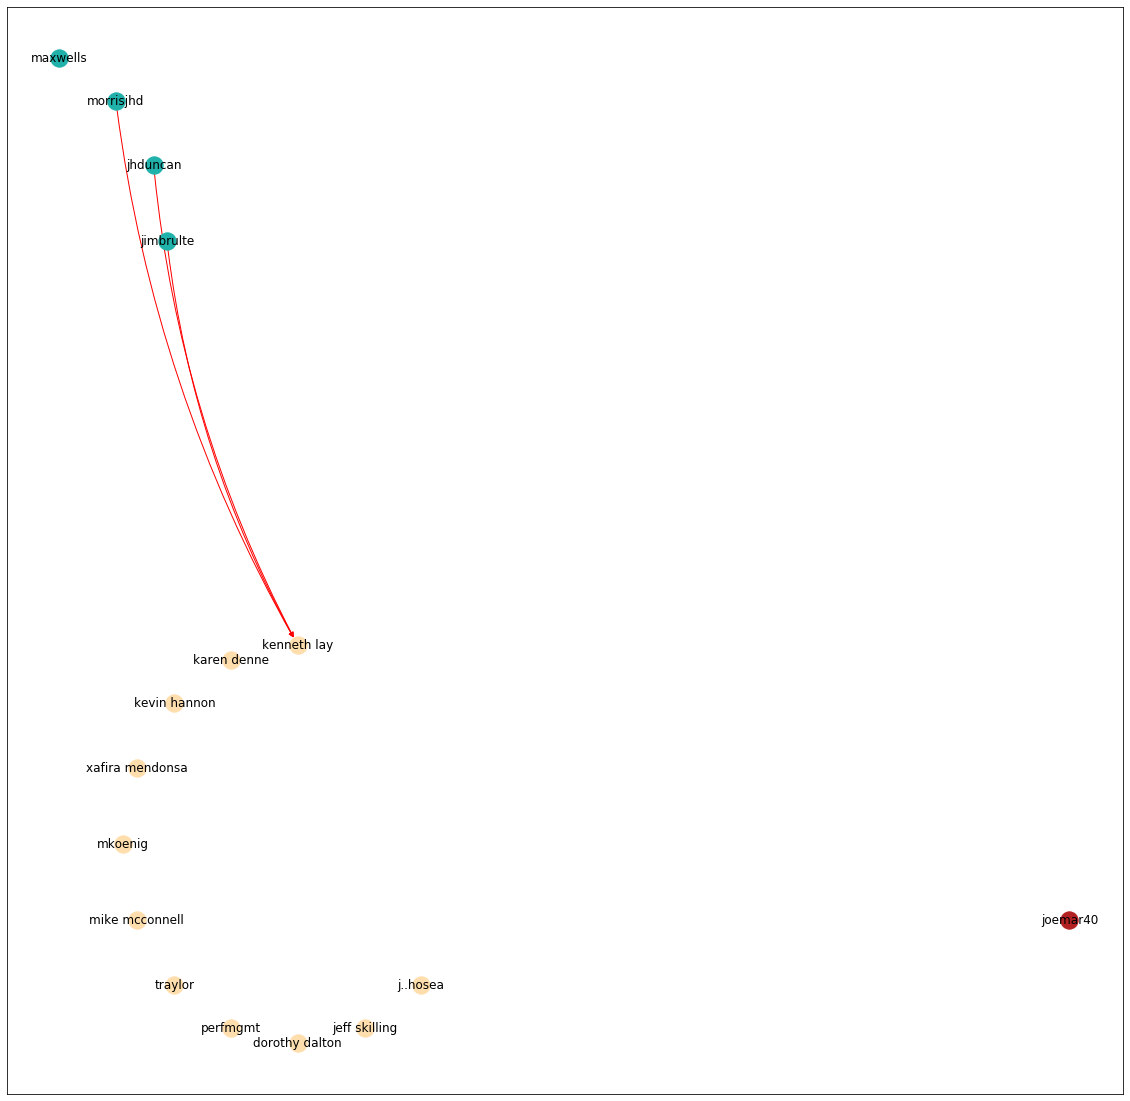

In [147]:
import numpy as np

pos, nodes_by_color = grouped_layout(G, rad=3.5)

#################################

# First draw the nodes 
plt.figure(figsize=(20,20))
for color, node_names in nodes_by_color.items():
    nx.draw_networkx_nodes(G, pos=pos, nodelist=node_names, node_color=color, label={x:G.nodes[x]['label'] for x in G.nodes})

labels={x:G.nodes[x]['label'] for x in G.nodes}
nx.draw_networkx_edges(G, pos=pos, edgelist=list(G.edges)[:3], edge_color='red', connectionstyle='arc3, rad = 0.1')
nx.draw_networkx_labels(G, pos=pos, labels=labels)
plt.show()
pass;

In [150]:
from src.graph_utils import make_circos, get_centrality, get_betweenness

/home/mpark/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,name1,name2,email1,email2,org1,org2
0,,,,,enron,
1,component web services,,,,component web services,
2,vince kaminski,,,,enron,
3,cadvision,,,,cadvision,
4,vince kaminski,,,,enron,
...,...,...,...,...,...,...
71,mindspring,,,,mindspring,
72,vince kaminski,,,,enron,
73,weforum,,,,weforum,
74,rosalee fleming,,,,enron,


In [91]:
edges

,sender,receiver1,receiver2,receiver3,type,datetime,desc,data
0,0,1,,,invoice,1999-02-26,Project commencement invoice post kick-off mee...,7699.10
1,2,3,,,invoice,1999-05-17,Workforce Now\nADP Flexible Spending\nAccounts...,563.63
2,4,5,,,invoice,1999-06-21,ADP Workforce Now\nADP Flexible Spending\nAcco...,555.30
3,6,7,,,invoice,1999-08-08,Installed (-1-) customer supplied electric wat...,945.00
4,8,9,,,invoice,1999-08-19,Review materials from client re alleged fraud ...,3420.00
5,10,11,,,invoice,2000-01-17,,116.69
6,12,13,,,invoice,2000-06-18,,1160.89
7,14,15,,,invoice,2000-11-18,,1160.89
8,16,17,,,invoice,2000-12-21,Performed annual fire alarm inspection.\nRepor...,805.02
9,18,19,,,invoice,2001-11-05,Atomica Music License,1650.00


In [90]:
def invoice_to_edges(invoice):
    
    for i,row in inv.iterrows():
        edges_dict['name1'].append(row['recipient'].lower())
        edges_dict['name2'].append('')
        edges_dict['email1'].append('')
        edges_dict['email2'].append('')
        edges_dict['org1'].append('')
        edges_dict['org2'].append('')

In [70]:
graph.nodes.head()
graph.edges.head()

,name1,name2,email1,email2,org1,org2
0,,,zzmacmac@aol.com,,,
1,,,quigbe@aol.com,,,
2,quicktime news,,quicktime_news@applenews.lists.apple.com,,,
3,,,queen28cmh@aol.com,,,
4,,,quality@corp.classmates.com,,,


,sender,receiver1,receiver2,receiver3,type,datetime,desc,data
0,6779,1393,,,email,1979-12-31 16:00:00,Re: Update from cousins in Missouri,Letter dictated by Ken Lay Hello Janice: I enj...
1,4953,2794,,,email,1979-12-31 16:00:00,Re: Energy TF Final Report,Mr. Sikes - Kenneth L. Lay is the Chairman of ...
2,4380,9285,,,email,1979-12-31 16:00:00,"Re: BlueDog Change Order #2, Rev 4","Hi Brian, Here are my observations/questions: ..."
3,5816,4015,,,email,1979-12-31 16:00:00,Re: ERMS traders in EnPower,Enron Capital & Trade Resources Corp.
4,6439,9521,,,email,1979-12-31 16:00:00,,"George, In response to your ideas Time and cos..."


In [53]:
# fig, axs = plt.subplots(2, 1, figsize=(15, 8))

# cent = get_centrality(G)
# centplot = sns.barplot(ax=axs[0], y='centrality', x='name', data=cent.replace({r'\.com$':r''}, regex=True)[:10])
# axs[0].set_xlabel('Degree Centrality')
# axs[0].set_ylabel('')
# axs[0].set_title('Top Degree in Enron Network')
# plt.setp(centplot.get_xticklabels(), rotation=30)

# bet = get_betweenness(G)
# betplot = sns.barplot(ax=axs[1], y='betweenness', x='name', data=bet.replace({r'\.com$':r''}, regex=True)[:10])
# axs[1].set_xlabel('Degree Betweenness Centrality')
# axs[1].set_ylabel('')
# axs[1].set_title('Top Betweenness in Enron Network')
# plt.setp(betplot.get_xticklabels(), rotation=45)

# plt.subplots_adjust(hspace=0.5)
# pass;

In [54]:
from run_clean import name_org

In [55]:
names = nx.get_node_attributes(G, 'name')

['lightseagreen',
 'navajowhite',
 'firebrick',
 'darkseagreen',
 'lavenderblush',
 'darkgreen',
 'darkkhaki',
 'mintcream',
 'olivedrab',
 'greenyellow']

In [68]:
import string, random
import networkx as nx
import matplotlib.pyplot as plt
from scipy.sparse import random as sparse_random

random.seed(0)

# Random string generator
def rand_string(size=6, chars=string.ascii_uppercase):
    return ''.join(random.choice(chars) for _ in range(size))


# Set up a nodes and networks randomly
nodes = [rand_string() for _ in range(30)]
networks = [rand_string() for _ in range(5)]
networks_list = networks*6
random.shuffle(networks_list)

# Define what nodes belong to what network and what their color should be
node_network_map = dict(zip(nodes, networks_list))
colors = colors[:5]
color_map = dict(zip(networks, colors))


In [133]:
node_network_map

{'MYNBIQ': 'RNTDIC',
 'PMZJPL': 'AGFWDP',
 'SGQEJE': 'DUGTSD',
 'YDTZIR': 'RNTDIC',
 'WZTEJD': 'AGFWDP',
 'XCVKPR': 'RNTDIC',
 'DLNKTU': 'MCLDBT',
 'GRPOQI': 'DUGTSD',
 'BZRACX': 'DUGTSD',
 'MWZVUA': 'GXZBVA',
 'TPKHXK': 'GXZBVA',
 'WCGSHH': 'MCLDBT',
 'ZEZROC': 'RNTDIC',
 'CKQPDJ': 'DUGTSD',
 'RJWDRK': 'GXZBVA',
 'RGZTRS': 'GXZBVA',
 'JOCTZM': 'MCLDBT',
 'KSHJFG': 'AGFWDP',
 'FBTVIP': 'GXZBVA',
 'CCVYEE': 'AGFWDP',
 'BCWRVM': 'RNTDIC',
 'WQIQZH': 'MCLDBT',
 'GVSNSI': 'MCLDBT',
 'OPVUWZ': 'DUGTSD',
 'LCKTDP': 'GXZBVA',
 'SUKGHA': 'MCLDBT',
 'XIDWHL': 'RNTDIC',
 'ZFKNBD': 'DUGTSD',
 'ZEWHBS': 'AGFWDP',
 'URTVCA': 'AGFWDP'}

In [69]:
color_map

{'DUGTSD': 'lightseagreen',
 'MCLDBT': 'navajowhite',
 'AGFWDP': 'firebrick',
 'GXZBVA': 'darkseagreen',
 'RNTDIC': 'lavenderblush'}

In [70]:
nodes

['MYNBIQ',
 'PMZJPL',
 'SGQEJE',
 'YDTZIR',
 'WZTEJD',
 'XCVKPR',
 'DLNKTU',
 'GRPOQI',
 'BZRACX',
 'MWZVUA',
 'TPKHXK',
 'WCGSHH',
 'ZEZROC',
 'CKQPDJ',
 'RJWDRK',
 'RGZTRS',
 'JOCTZM',
 'KSHJFG',
 'FBTVIP',
 'CCVYEE',
 'BCWRVM',
 'WQIQZH',
 'GVSNSI',
 'OPVUWZ',
 'LCKTDP',
 'SUKGHA',
 'XIDWHL',
 'ZFKNBD',
 'ZEWHBS',
 'URTVCA']

In [71]:
networks

['DUGTSD', 'MCLDBT', 'AGFWDP', 'GXZBVA', 'RNTDIC']

In [72]:
node_network_map

{'MYNBIQ': 'RNTDIC',
 'PMZJPL': 'AGFWDP',
 'SGQEJE': 'DUGTSD',
 'YDTZIR': 'RNTDIC',
 'WZTEJD': 'AGFWDP',
 'XCVKPR': 'RNTDIC',
 'DLNKTU': 'MCLDBT',
 'GRPOQI': 'DUGTSD',
 'BZRACX': 'DUGTSD',
 'MWZVUA': 'GXZBVA',
 'TPKHXK': 'GXZBVA',
 'WCGSHH': 'MCLDBT',
 'ZEZROC': 'RNTDIC',
 'CKQPDJ': 'DUGTSD',
 'RJWDRK': 'GXZBVA',
 'RGZTRS': 'GXZBVA',
 'JOCTZM': 'MCLDBT',
 'KSHJFG': 'AGFWDP',
 'FBTVIP': 'GXZBVA',
 'CCVYEE': 'AGFWDP',
 'BCWRVM': 'RNTDIC',
 'WQIQZH': 'MCLDBT',
 'GVSNSI': 'MCLDBT',
 'OPVUWZ': 'DUGTSD',
 'LCKTDP': 'GXZBVA',
 'SUKGHA': 'MCLDBT',
 'XIDWHL': 'RNTDIC',
 'ZFKNBD': 'DUGTSD',
 'ZEWHBS': 'AGFWDP',
 'URTVCA': 'AGFWDP'}

In [62]:
graph = nx.Graph()
graph.add_nodes_from(nodes)
nodes_by_color = {val: [node for node in graph if color_map[node_network_map[node]] == val]
                  for val in colors}

In [63]:
nodes_by_color

{'lightseagreen': ['APSFIJ', 'AENRLT', 'VZRMMM', 'DPOPPJ', 'YGZHMX', 'MZWYGP'],
 'navajowhite': ['CFEHVH', 'SKEWQT', 'AYQJUC', 'YHRRYQ', 'XAAZIP', 'PTTAPU'],
 'firebrick': ['UVXBOY', 'KTBDAS', 'CEDXKX', 'IPWFQA', 'GQLEWR', 'ZHGQPL'],
 'darkseagreen': ['GCGOFD', 'ERDLTA', 'KUHTZZ', 'IGWTLO', 'LZUCVD', 'FNZUKC'],
 'lavenderblush': ['MDPUMB', 'CGTMEU', 'ILTLPD', 'WIQLFL', 'ZXLLCH', 'DHPGKG']}

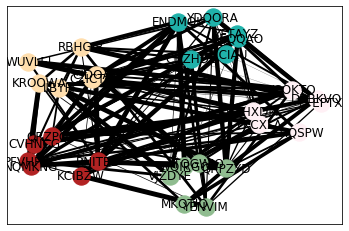

In [64]:
import string, random
import networkx as nx
import matplotlib.pyplot as plt
from scipy.sparse import random as sparse_random


# Random string generator
def rand_string(size=6, chars=string.ascii_uppercase):
    return ''.join(random.choice(chars) for _ in range(size))


# Set up a nodes and networks randomly
nodes = [rand_string() for _ in range(30)]
networks = [rand_string() for _ in range(5)]
networks_list = networks*6
random.shuffle(networks_list)

# Define what nodes belong to what network and what their color should be
node_network_map = dict(zip(nodes, networks_list))
colors = colors[:5]
color_map = dict(zip(networks, colors))

graph = nx.Graph()
graph.add_nodes_from(nodes)
nodes_by_color = {val: [node for node in graph if color_map[node_network_map[node]] == val]
                  for val in colors}

# Take random sparse matrix as adjacency matrix
mat = sparse_random(30, 30, density=0.3).todense()
for row, row_val in enumerate(nodes):
    for col, col_val in enumerate(nodes):
        if col > row and mat[row, col] != 0.0: # Stick to upper half triangle, mat is not symmetric
            graph.add_edge(row_val, col_val, weight=mat[row, col])

# Choose a layout to visualize graph
######################## pos = nx.spring_layout(graph)


import numpy as np
pos = nx.circular_layout(graph)   # replaces your original pos=...
# prep center points (along circle perimeter) for the clusters
angs = np.linspace(0, 2*np.pi, 1+len(colors))
repos = []
rad = 3.5     # radius of circle
for ea in angs:
    if ea > 0:
        #print(rad*np.cos(ea), rad*np.sin(ea))  # location of each cluster
        repos.append(np.array([rad*np.cos(ea), rad*np.sin(ea)]))
        
color_pos = dict(zip(nodes_by_color.keys(), range(len(nodes_by_color))))

for ea in pos.keys():
    #color = 'black'
    posx = 0
    
    for c, p in color_pos.items():
        
        if ea in nodes_by_color[c]:
            #color = 'green'
            posx = p

    #print(ea, pos[ea], pos[ea]+repos[posx], color, posx)
    pos[ea] += repos[posx]


#################################
edges = graph.edges()

# Get the edge weights and normalize them 
weights = [abs(graph[u][v]['weight']) for u, v in edges]
weights_n = [5*float(i)/max(weights) for i in weights] # Change 5 to control thickness

# First draw the nodes 
plt.figure()
for color, node_names in nodes_by_color.items():
    nx.draw_networkx_nodes(graph, pos=pos, nodelist=node_names, node_color=color)

# Then draw edges with thickness defined by weights_n
nx.draw_networkx_edges(graph, pos=pos, width=weights_n)
nx.draw_networkx_labels(graph, pos=pos)
plt.show()
pass;

# Embeddings

In [9]:
import re

def emails_to_sentences(data):
    df_dict = {k:[] for k in data.columns}
    df_dict.pop('text')
    idx = []
    sentence = []
    
    for i, row in data.iterrows():
        sents = re.split(r'(?<=[a-z]{2})\.|\?|\!', row.text)
        n_sents = len(sents)
        for k in df_dict.keys():
            df_dict[k].extend([row[k]]+['']*(n_sents-1))
        idx.extend([i]*n_sents)
        sentence.extend(sents)
    df_dict['idx'] = idx
    df_dict['sentence'] = sentence
    return pd.DataFrame(df_dict)

In [10]:
emails_to_sentences(data)

,date,subject,sender,recipient1,recipient2,recipient3,idx,sentence
0,2001-01-01 02:59:00,12/31 Actuals,jeffrey.porter@enron,ena.nominations@enron,,,0,"email problems, No temps yet, same as for cast"
1,2001-01-01 06:23:00,Merry Christmas,ps5@cmu,vince.j.kaminski@enron,,,1,"Dear Mr. Kaminski, In the name of all the MSCF..."
2,,,,,,,1,Thank you very much for taking the time to co...
3,,,,,,,1,It was greatly appreciated
4,,,,,,,1,"Best regards, Pierre"
...,...,...,...,...,...,...,...,...
196357,,,,,,,40961,References: Oak Forest Elementary Betty Polla...
196358,2044-01-04 08:59:46,Trades,cramer@cadvision,john.zufferli@enron,,,40962,"BOM 5th to 31st traded 34, 33.5 , 33.5 and 34 ..."
196359,,,,,,,40962,q2 traded 32 and 31.5. feb dec traded 35 smal...
196360,2044-01-04 14:48:58,trades,cramer@cadvision,john.zufferli@enron,,,40963,"Howdy, bom went out 35 at 35.5 Feb traded 32.7..."


In [28]:
import torch
import dataclasses
from dataclasses import dataclass
from typing import Any, Callable, Dict, List, Optional, Set, Tuple, Union

from transformers import (
    XLNetModel, 
    XLNetPreTrainedModel, 
    BertPreTrainedModel,
    BertModel,
    T5PreTrainedModel,
    T5Model,
    AutoConfig,
    AutoTokenizer,
)

class BertLastHidden(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config)
        self.init_weights()
        
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        return outputs.last_hidden_state
    
class EmailDataset(torch.utils.data.Dataset):
    def __init__(self, features):
        self.features = features
        self.label_list = [x.label for x in features]

    def __len__(self):
        return len(self.features)

    def __getitem__(self, i):
        return self.features[i]

    def get_labels(self):
        return self.label_list

class EmailDataCollator:
    def __init__(self, config):
        self.config = config
        
    def _tensorize(self, name, features, dtype):
        return torch.tensor([f.__dict__[name] for f in features], dtype=dtype).unsqueeze(-1)
        
    def __call__(self, features):
        first = features[0]
        batch = {}

        for k,v in first.__dict__.items():
            if isinstance(v, str) or v is None:
                pass
            elif k=='label' or k=='seq_mask':
                batch[k] = self._tensorize(k, features, torch.long)
            elif self.config[k].vector=='embedding':
                batch[k] = self._tensorize(k, features, torch.long)
            elif self.config[k].vector=='onehot':
                batch[k] = one_hot(self._tensorize(k, features, torch.long), self.config[k].size).unsqueeze(1)
            elif self.config[k].vector=='linear':
                batch[k] = self._tensorize(k, features, torch.float).unsqueeze(-1)
            else:
                raise ValueError("unknown vectorization scheme {}".format(self.config[k].vector))
                
            if type(v)==list:
                batch[k] = batch[k].squeeze(-1)
        return batch

In [29]:
pooling_parameters = {
    "summary_activation": "tanh",
    "summary_last_dropout": 0.1,
    "summary_type": "mean",
    "summary_use_proj": True
}

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased', cache_dir=None, use_fast=True)
config = AutoConfig.from_pretrained('bert-base-cased', finetuning_task='mnli', cache_dir=None)
config.update(pooling_parameters)

embedding = BertLastHidden.from_pretrained('bert-base-cased', from_tf=False, config=config, cache_dir=None)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertLastHidden: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertLastHidden from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertLastHidden from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [34]:
testy = [tokenizer(x, padding='max_length', max_length=80, truncation=True) for x in data.text[:10]][0]
testy = {k:[v] for k,v in testy.items()}
testy

{'input_ids': [[101,
   10632,
   2645,
   117,
   1302,
   21359,
   15279,
   1870,
   117,
   1269,
   1112,
   1111,
   2641,
   102,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0]],
 'token_type_ids': [[0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
  

In [37]:
embedding(**{k:torch.LongTensor(v).to_sparse() if k=='input_ids' else torch.LongTensor(v) for k,v in testy.items()})

RuntimeError: reshape is not implemented for sparse tensors

In [16]:
data

,date,subject,sender,recipient1,recipient2,recipient3,text
0,2001-01-01 02:59:00,12/31 Actuals,jeffrey.porter@enron,ena.nominations@enron,,,"email problems, No temps yet, same as for cast"
1,2001-01-01 06:23:00,Merry Christmas,ps5@cmu,vince.j.kaminski@enron,,,"Dear Mr. Kaminski, In the name of all the MSCF..."
2,2001-01-01 08:36:00,Re: Gas Team - Reorg,john.arnold@enron,edie.leschber@enron,,,that info is correct.
3,2001-01-01 08:36:00,Re:,john.arnold@enron,john.lavorato@enron,,,i would have paid you in full Tueday morning a...
4,2001-01-01 08:55:00,,john.arnold@enron,mike.maggi@enron,,,"if we were open today, where would you open it?"
...,...,...,...,...,...,...,...
40959,2004-02-03 18:19:15,Your code,chaseonlineplus@chase,vladi.pimenov@enron,,,You have requested an authorization code to va...
40960,2004-02-03 18:37:41,Give holiday gifts your personal touch!,1800flowers.215124894@s2u2,rshapiro@enron,,,"Dear Richard, Send personalized holiday treasu..."
40961,2007-02-11 13:32:50,Maud Gordon Elementary Sound,rwalker802@earthlink,kevin.hyatt@enron,,,Here is the sound system proposal. References:...
40962,2044-01-04 08:59:46,Trades,cramer@cadvision,john.zufferli@enron,,,"BOM 5th to 31st traded 34, 33.5 , 33.5 and 34 ..."


In [17]:
[tokenizer(x, padding='max_length', max_length=80, truncation=True) for x in data.text[:10]][0]

{'input_ids': [101, 10632, 2645, 117, 1302, 21359, 15279, 1870, 117, 1269, 1112, 1111, 2641, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [8]:
import logging
from transformers import set_seed, AutoConfig, AutoTokenizer
from transformers.trainer_utils import is_main_process
from src.nlp.glue_utils import (
    ModelArguments, 
    DataTrainingArguments, 
    TrainingArguments, 
    get_labels,
    get_label_to_id,
    GluePreprocessor, 
    AutoPreprocessor,
    ComputeMetrics
)
from datasets import DatasetDict

model_args = ModelArguments(model_name_or_path='bert-base-cased')
data_args = DataTrainingArguments(task_name='mnli', max_seq_length=80)
training_args = TrainingArguments(
    do_train=True, do_eval=True, 
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=2e-5, num_train_epochs=4.0,
    output_dir='test_bert_d768_l80',
    overwrite_output_dir=True,
    evaluation_strategy='steps',
    eval_accumulation_steps=1,
    logging_steps=500,
    eval_steps=500,
    local_rank=-1
)

set_seed(9999)

logger = logging.getLogger(__name__)
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO if is_main_process(training_args.local_rank) else logging.WARN,
    )

tokenizer = AutoTokenizer.from_pretrained(
    model_args.model_name_or_path,
    cache_dir=model_args.cache_dir,
    use_fast=model_args.use_fast_tokenizer,
)

config = AutoConfig.from_pretrained(
    model_args.model_name_or_path,
    finetuning_task=data_args.task_name,
    cache_dir=model_args.cache_dir,
)

dataset_dict = DatasetDict()
dataset_dict = dataset_dict.load_from_disk('data/nli/mnli_snli_hans')

config.update(get_labels(data_args, dataset_dict))
config.update(get_label_to_id(data_args, config))
config.update({
    "summary_activation": "tanh",
    "summary_last_dropout": 0.1,
    "summary_type": "mean",
    "summary_use_proj": True
})

ModuleNotFoundError: No module named 'src'